# Goal
- implement the gradient-based learning using sampling
- implement the EM method
- compare the two using synthetic data

# Introduction
Our goal in this exercise is to learn the parameters of a model from incomplete data. The model is a mixture of Guassians. According to this model, each data point is sampled from one of $C$ Gaussian distributions, according to the class of that data point. The prior probability for class label follows a multinomial distribution:

\begin{equation}
P(Z_i = j) = p_j 
\end{equation}

Given the class of a data point, its value follows a normal distribution with parameters that are specific to that class:

\begin{equation}
P(Y_i = y | Z_i = j) = N(y; \mu_j, \sigma_j)
\end{equation}

## Sampling the latent variables
For each data point $Y_i$ we have:

\begin{align*}
P(Z_i=j|Y_i=y_i;\Theta) & \propto P(Y_i=y_i|Z_i=j;\Theta)P(Z_i=j;\Theta)   \\
                  & = N(y_i;\mu_j,\sigma_j) \cdot p_j
\end{align*}

Having the posterior of class label, we can sample the label from this posterior:

In [2]:
from scipy.stats import norm
from numpy.random import multinomial

# returns a vector with counts of each class
def sample_label(parameters, y, num_samples=1):
    multinomial_parameters, normal_parameters = parameters
    assert len(multinomial_parameters) == len(normal_parameters)
    num_classes = len(multinomial_parameters)
    
    posterior = [0.0] * num_classes
    for i in range(num_classes):
        mu, sigma = normal_parameters[i]
        p = multinomial_parameters[i]
        posterior[i] = norm.pdf(y, loc=mu, scale=sigma) * p
    s = sum(posterior)
    posterior = [ps/s for ps in posterior]
    return multinomial(num_samples, posterior)
    


Let us test the correctness of gradients of normal distribution. Given $f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{\frac{(x-\mu)^2}{2\sigma^2}}$, I believe that:
\begin{align}
\frac{\partial f}{\partial \mu} &= f . \frac{1}{\sigma} . \big(\frac{x-\mu}{\sigma}\big) \\
\frac{\partial f}{\partial \sigma} &= f . \frac{1}{\sigma} . \big( (\frac{x-\mu}{\sigma})^2 -1 \big)
\end{align}

In [118]:
from scipy.optimize import check_grad
from scipy.stats import norm
from numpy.random import random_sample, normal

def f_normal(x):
    def _f(inp):
        mu, sigma = inp
        return norm.pdf(x, loc=mu, scale=sigma)
    return _f

def fprime_normal(x):
    def _fprime(inp):
        f_val = f(x)(inp)
        mu, sigma = inp
        xms = (x-mu)/sigma
        
        grad=[0.0]*2
        grad[0] = f_val/sigma * xms
        grad[1] = f_val/sigma * (xms**2 - 1)
        return grad
    return _fprime

# for i in range(10000):
#     mu = 30 * random_sample()
#     sigma = 10 * random_sample()
#     val = normal(mu, sigma)
#     diff =  check_grad(f(val), fprime(val), [mu, sigma])
#     if diff > 1e-4:
#         print mu, sigma, val, diff

In [63]:
from numpy.random import random_sample, normal
from scipy.stats import norm

def f_normal_log(x):
    return lambda y : norm.logpdf(x, loc=y[0], scale=y[1])

def fprime_normal_log(x):
    def fprime_log_(y):
        mu, sigma = y
        xms = (x-mu)/sigma
        fprime_mu = xms / sigma
        fprime_sigma = (xms**2 - 1) / sigma
        return (fprime_mu, fprime_sigma)
    return fprime_log_

for i in range(5000):
    mu = 30 * random_sample()
    sigma = 10 * random_sample()
    val = normal(mu, sigma)
    diff =  check_grad(f_normal_log(val), fprime_normal_log(val), [mu, sigma])
    if diff > 1e-4:
        print mu, sigma, val, diff

28.2928469665 0.00592172043732 28.2863311113 0.000598214503615
8.96909573673 0.000621093559227 8.96901323197 0.0266009950405
28.1549881946 0.0068173659069 28.1529651645 0.000199039264796
9.80309539067 0.00749007908259 9.81579395677 0.00102107474286
19.9941297072 0.00911564481845 19.9917446729 0.00011452526983
25.5092916176 0.0221553537523 25.4729479686 0.000108410052508
27.9116999558 0.00186872685539 27.9092031722 0.00953395716171
10.0643932165 0.00784502673061 10.0624190567 0.000155770172607
29.1572354162 0.00705287246878 29.1434574364 0.00157213412558
2.32903647632 0.00168510148118 2.32796070813 0.0026881099904
7.45309686299 0.01909445103 7.41427392373 0.000233930416804


In [120]:
def test_multinomial(f_multinomial_pos, fprime_multinomial_pos, 
                    num_tests = 1000):
    num_classes = np.random.randint(40)
    for i in range(num_tests):
        params = [normal(loc=0, scale=1) for i in range(num_classes)]
        p2 = np.exp(params)
        p2 = [i/sum(p2) for i in p2]
        val = multinomial(1, p2)
        val = numpy.where(val==1)[0][0]
        diff =  check_grad(f_multinomial_pos(val), fprime_multinomial_pos(val), params)
        if diff > 1e-4:
            print params, val, diff
            print f_multinomial_pos(val)(params) 
            print fprime_multinomial_pos(val)(params)
            print approx_fprime(params, f_multinomial_pos(val), 1.49e-08)
            print 
    print 'test finished'

In [36]:
def f_multinomial_pos(label):
    return (lambda parameters : np.exp(parameters[label]) / sum(np.exp(parameters)))

def fprime_multinomial_pos(label):
    def _fprime_multinomial_pos(parameters):
        f = [f_multinomial_pos(i)(parameters) for i in range(len(parameters))]
        f_i = f[label]
        fprime = [-f_i*f_j for f_j in f]
        fprime[label] = f_i*(1-f_i)
        return fprime
    return _fprime_multinomial_pos

test_multinomial(f_multinomial_pos, fprime_multinomial_pos)

test finished


In [121]:
def f_multinomial_log(label):
    return (lambda parameters : parameters[label] - np.log(sum(np.exp(parameters))))

def fprime_multinomial_log(label):
    def _fprime_multinomial_log(parameters):
        fprime = [-f_multinomial_pos(i)(parameters) for i in range(len(parameters))]
        fprime[label] += 1
        return fprime
    return _fprime_multinomial_log
    
test_multinomial(f_multinomial_log, fprime_multinomial_log)    

NameError: global name 'numpy' is not defined

## Approximating the gradient
The log likelihood of data point $i$ can be written as $L(\Theta) = \log P(Y_i, Z_i;\Theta)$. 
So the gradient of log-likelihood function can be written as:

\begin{equation}
\partial_{\Theta} L(\Theta) = 
\end{equation}

In [113]:
def ll(parameters, data):
    """Compute the likelihood and its gradients.
    
    arguments:
    parameters -- current value of parameters
    data     -- values for all random variables
    """
    p_n, p_m = parameters
    likelihood = 0
    grad_n = [0.0] * len(p_n[0])
    grad_m = [0.0] * len(p_m)
    for instance in data:
        label, value = instance
        likelihood += f_normal_log(value)(p_n[label])
        grad_n += fprime_normal_log(value)(p_n[label])
        likelihood += f_multinomial_log(label)(p_m)
        grad_m += fprime_multinomial_log(label)(p_m)
    
    gradients = grad_n, grad_m
    return likelihood, gradients






## A very important observation
The differences in the values of `multinomial_parameters` leads to exponential differences, and does not let samples from other classes to be generated. 

In [97]:
import numpy as np

def generate_data():
    num_classes = 2
    normal_parameters = [
        [10, 5],
        [25, 3]
    ]
    multinomial_parameters = [15.5, 16]
    p2 = np.exp(multinomial_parameters)
    p2 = [i/sum(p2) for i in p2]
    
    num_data = 1000
    values = []
    labels = []
    for i in range(num_data):
        label = np.random.multinomial(1, p2)
        label = np.where(label==1)[0][0]
        mu, sigma = normal_parameters[label]
        value = np.random.normal(mu, sigma)
        values.append(value)
        labels.append(label)
    return values, labels

values, labels = generate_data()
data = zip(labels, values)

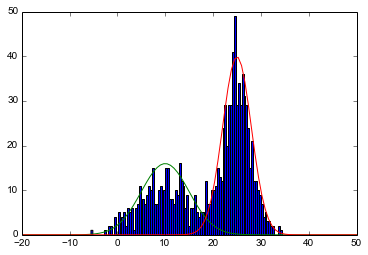

In [96]:
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.hist(values,100)
x = np.linspace(-20, 50, num=100)
y1 = norm.pdf(x, loc=10, scale=5) * 200
y3 = norm.pdf(x, loc=25, scale=3) * 300
plt.plot(x, y1)
plt.plot(x, y3)

Assuming that the class labels are hidden, we only have access to `values`. In each iteration, we complete the data using current parameters, compute the likelihood and gradient of completed data, and update the parameters:

In [117]:
# returns a vector with counts of each class
def complete_data(parameters, value, num_samples=1):
    normal_parameters, multinomial_parameters = parameters
    assert len(multinomial_parameters) == len(normal_parameters)
    num_classes = len(multinomial_parameters)
    p = np.exp(multinomial_parameters)
    p = [pj/sum(p) for pj in p]
    
    posterior = [0.0] * num_classes
    for i in range(num_classes):
        mu, sigma = normal_parameters[i]
        posterior[i] = norm.pdf(value, loc=mu, scale=sigma) * p[i]
    s = sum(posterior)
    posterior = [ps/s for ps in posterior]
    labels =  np.random.multinomial(num_samples, posterior)
    return [(label, value) for label in labels]

def iterate(parameters):
    completed_data = []
    for value in values:
        completed_data.append(complete_data(parameters, value))
    likelihood, gradients = ll(parameters, completed_data)
    parameters = parameters - alpha * gradients
    return parameters

normal_parameters = [
    [10, 5],
    [25, 3]
]

multinomial_parameters = [15.5, 16]
parameters = normal_parameters, multinomial_parameters
print parameters
print iterate(parameters)

([[10, 5], [25, 3]], [15.5, 16])


NameError: global name 'f_normal_log' is not defined